# Large scale text analysis with deep learning (3 points)

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

_Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

Хай, май нейм из Виктор Кенк энд this код ис май лаборатори ворк :)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from [here]. 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [2]:
!wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
!unzip Train_rev1.zip
data = pd.read_csv("Train_rev1.csv", index_col=None)
data.shape

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"unzip" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


(244768, 12)

In [3]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

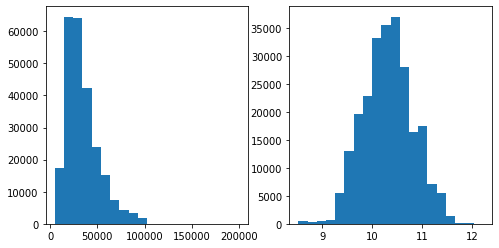

In [4]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [5]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"
data[text_columns] = data[text_columns].fillna('NaN')

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
80823,69023530,ICT Supplier and Contracts Officer,The Supplier & Contracts Officer will be respo...,"Warrington, Greater Manchester",UK,NaN,contract,Coyle Personnel,Other/General Jobs,18/hour,34560,cv-library.co.uk,10.450481
160450,71185863,Engineering Team Lead,Peek Traffic Ltd Engineering Team Lead Basings...,Basingstoke Hampshire South East,Basingstoke,NaN,permanent,PEEK TRAFFIC LTD,Other/General Jobs,"Up to 55,000 per annum",55000,totaljobs.com,10.915107
60672,68694094,Information Security Officer / IT Security Ana...,The Company Robert Half Technology are working...,City London South East,London,NaN,permanent,Robert Half Technology,Accounting & Finance Jobs,65000 - 75000 per annum + bonus & benefits,70000,totaljobs.com,11.156265


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [6]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [7]:
import nltk
#TODO YOUR CODE HERE

tokenizer = nltk.tokenize.WordPunctTokenizer()
# YOUR CODE HERE

data[text_columns] = data[text_columns].applymap(lambda x: " ".join(tokenizer.tokenize(x.lower())))

Now we can assume that our text is a space-separated list of tokens:

In [8]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [9]:
from collections import Counter
token_counts = Counter()
# Count how many times does each token occur in both "Title" and "FullDescription" in total
#TODO <YOUR CODE>

for col in text_columns:
    for line in data[col].values:
        token_counts.update(line.split(" "))

In [10]:
  print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


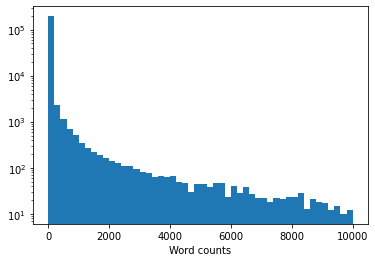

In [11]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [12]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
#TODO <YOUR CODE>
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [13]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [14]:
# TODO <YOUR CODE>
token_to_id = {t: i for i, t in enumerate(tokens)}

In [15]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [16]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [17]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [18]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [19]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=77)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [20]:
import torch

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, max_len=None, word_dropout=0, device=torch.device('cpu')):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [21]:
make_batch(data_train[:3], max_len=10)

{'Title': tensor([[27645, 26986,  1587,   197, 11192,  1700],
         [27280, 13650, 30409,  2844,     1,     1],
         [ 4986,  9083, 18864,     1,     1,     1]]),
 'FullDescription': tensor([[32937, 31100, 33664, 12587,   982, 17753, 11192,  1693,   943,  8110],
         [ 2572, 33996,   982, 13650,   158, 33554,   982,   437, 22021,    82],
         [33996, 33435, 30323, 33554,  3002, 20893, 11312,   158,  7151, 31100]]),
 'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'Log1pSalary': tensor([10.5967,  9.5325, 10.4631])}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use PyTorch.

In [22]:
import torch
import torch.nn as nn
import torch.functional as F

In [23]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        #  YOUR CODE HERE

        
    def forward(self, batch):
        # YOUR CODE HERE
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [24]:
model = SalaryPredictor()

In [25]:
model = SalaryPredictor()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(np.unique(dummy_pred.detach().numpy())) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [26]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            yield batch
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [27]:
import tqdm

BATCH_SIZE = 128
EPOCHS = 3
DEVICE = torch.device('cuda')

In [28]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
            batch_pred = model(batch)
            squared_error += torch.mean(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.mean(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae

In [29]:
model = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
        model.train()
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()

        if i % 100 == 99:
            print('train_loss', loss.item())
            print_metrics(model, data_val, name='val', batch_size=BATCH_SIZE, device=DEVICE)

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 39.18674850463867
val results:
Mean square error: 11.10848
Mean absolute error: 1.66160
train_loss 0.5022580623626709
val results:
Mean square error: 0.60445
Mean absolute error: 0.35671
train_loss 0.5287799835205078
val results:
Mean square error: 0.55601
Mean absolute error: 0.34466
train_loss 0.5435547828674316
val results:
Mean square error: 0.55280
Mean absolute error: 0.34728
train_loss 0.31716862320899963
val results:
Mean square error: 0.53329
Mean absolute error: 0.34300
train_loss 0.31949102878570557
val results:
Mean square error: 0.54058
Mean absolute error: 0.34757
train_loss 0.23707890510559082
val results:
Mean square error: 0.53955
Mean absolute error: 0.34860
train_loss 0.24107620120048523
val results:
Mean square error: 0.53101
Mean absolute error: 0.34668
train_loss 0.20287807285785675
val results:
Mean square error: 0.53266
Mean absolute error: 0.34808
train_loss 0.17421306669712067
val results:
Mean square error: 0.50989
Mean absolute error: 0.34057
trai

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.15527833998203278
val results:
Mean square error: 0.46261
Mean absolute error: 0.32594
train_loss 0.18076731264591217
val results:
Mean square error: 0.45324
Mean absolute error: 0.32255
train_loss 0.15134185552597046
val results:
Mean square error: 0.45582
Mean absolute error: 0.32376
train_loss 0.17249725759029388
val results:
Mean square error: 0.42113
Mean absolute error: 0.31031
train_loss 0.09501038491725922
val results:
Mean square error: 0.42918
Mean absolute error: 0.31370
train_loss 0.15084807574748993
val results:
Mean square error: 0.41923
Mean absolute error: 0.30995
train_loss 0.12831063568592072
val results:
Mean square error: 0.40255
Mean absolute error: 0.30335
train_loss 0.16282078623771667
val results:
Mean square error: 0.37844
Mean absolute error: 0.29344
train_loss 0.13525640964508057
val results:
Mean square error: 0.39133
Mean absolute error: 0.29899
train_loss 0.1308297961950302
val results:
Mean square error: 0.38244
Mean absolute error: 0.29541
t

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.13183096051216125
val results:
Mean square error: 0.30321
Mean absolute error: 0.26093
train_loss 0.11664220690727234
val results:
Mean square error: 0.33061
Mean absolute error: 0.27375
train_loss 0.13893504440784454
val results:
Mean square error: 0.31292
Mean absolute error: 0.26576
train_loss 0.11026822030544281
val results:
Mean square error: 0.34673
Mean absolute error: 0.28118
train_loss 0.14798682928085327
val results:
Mean square error: 0.32388
Mean absolute error: 0.27098
train_loss 0.10947026312351227
val results:
Mean square error: 0.27221
Mean absolute error: 0.24631
train_loss 0.13602539896965027
val results:
Mean square error: 0.29348
Mean absolute error: 0.25688
train_loss 0.1659209132194519
val results:
Mean square error: 0.28196
Mean absolute error: 0.25133
train_loss 0.10443275421857834
val results:
Mean square error: 0.27299
Mean absolute error: 0.24694
train_loss 0.1093248575925827
val results:
Mean square error: 0.26899
Mean absolute error: 0.24511
tr

# 1. Развейте СNN архитектуру (2 балла)

Добавьте в пайплайн

*   Batch Norm (nn.BatchNorm), LayerNorm...
*   Параллельные сверточные слои. Идея в том, чтобы применить несколько nn.Conv1d к одному и тому же эмбеддингу и после этого сконкатенировать выходные каналы
*   Больше слоев...
*   Добавьте раннюю остановку

На каких примерах модели ведут себя максимально различно/похоже? Предположите с чем это может быть связано. 

Как модель ведет себя в зависимости от количества обучаемых параметров?

Улучшим процесс обучения, добавим раннюю остановку и запись статистики, чтобы нарисовать графики

In [30]:
# model = SalaryPredictor().to(DEVICE)
# criterion = nn.MSELoss(reduction='mean')
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


def train_model(model):
    criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    stats_mse = []
    stats_mae = []
    stats_loss = []
    marker = 0
    con = True
    past_loss = 10**10
    for epoch in range(EPOCHS):
        if con:
            pass
        else:
            print("Stop training, early stop!")
        print(f"epoch: {epoch + 1}")
        for i, batch in tqdm.notebook.tqdm(enumerate(
                iterate_minibatches(
                        data_train, 
                        batch_size=BATCH_SIZE, 
                        device=DEVICE)), 
                    total=len(data_train) // BATCH_SIZE
            ):
            model.train()
            pred = model(batch)
            optimizer.zero_grad()
            loss = criterion(pred, batch[TARGET_COLUMN])
            loss.backward()
            optimizer.step()
            l = loss.item()
            if l > past_loss:
                marker = 0
            if marker > 8:
                print("8 times loss not decreased!")
                con = False
                break
            past_loss=l
            if i % 100 == 99:
                print('train_loss', loss.item())
                stats_loss.append(loss.item())
                s, a =print_metrics(model, data_val, name='val', batch_size=BATCH_SIZE, device=DEVICE)
                stats_mse.append(s)
                stats_mae.append(a)
    plt.figure()
    plt.plot(stats_loss, color="red")
    plt.plot(stats_mae)
    plt.plot(stats_mse)
    plt.title("Statisctics (Training)")
    plt.show()

In [31]:
class SalaryPredictor1(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        
        # Часть пайплайна через которую будет проходить данные
        def module(hid_size):
            
            module =  nn.Sequential(

                nn.Conv1d(hid_size, hid_size, kernel_size=2),

                nn.LazyBatchNorm1d(),

                nn.Dropout(p=0.2),

                nn.ReLU(),

                nn.AdaptiveMaxPool1d(output_size=1)
            )
            
            return module

        
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.conv1 = module(hid_size)
        self.conv2 = module(hid_size)
        self.conv1 = module(hid_size)
        self.conv2 = module(hid_size)
        
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 4),
            nn.ReLU(),
            nn.Linear(hid_size * 4, hid_size * 2),
            nn.ReLU()
        )
        
        self.final_predictor = nn.Sequential(
            nn.LazyLinear(hid_size   ),
            nn.ReLU(),
            nn.LazyLinear(1),
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features1 = self.conv1(title_embeddings).squeeze()
        title_features2 = self.conv2(title_embeddings).squeeze()
        title_features = torch.cat([title_features1,title_features2,],dim=1)

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features1 = self.conv1(title_embeddings).squeeze()
        description_features2 = self.conv2(title_embeddings).squeeze()
        
        description_features = torch.cat([description_features1,description_features2,],dim=1)
        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [32]:
m1 = SalaryPredictor1()
m1=m1.to(DEVICE)

epoch: 1


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 5.956198692321777
val results:
Mean square error: 1.56831
Mean absolute error: 0.48936
train_loss 2.59907603263855
val results:
Mean square error: 0.58899
Mean absolute error: 0.29679
train_loss 1.955595850944519
val results:
Mean square error: 0.38130
Mean absolute error: 0.24521
train_loss 0.9957832098007202
val results:
Mean square error: 0.29406
Mean absolute error: 0.22035
train_loss 0.8632099628448486
val results:
Mean square error: 0.12624
Mean absolute error: 0.13855
train_loss 0.5137854814529419
val results:
Mean square error: 0.15203
Mean absolute error: 0.15751
train_loss 0.3133937120437622
val results:
Mean square error: 0.10004
Mean absolute error: 0.12541
train_loss 0.2590220272541046
val results:
Mean square error: 0.08630
Mean absolute error: 0.11653
train_loss 0.22664397954940796
val results:
Mean square error: 0.07291
Mean absolute error: 0.10671
train_loss 0.21168264746665955
val results:
Mean square error: 0.07615
Mean absolute error: 0.11038
train_loss 0

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.18069538474082947
val results:
Mean square error: 0.05218
Mean absolute error: 0.08967
train_loss 0.17195425927639008
val results:
Mean square error: 0.04702
Mean absolute error: 0.08459
train_loss 0.16244010627269745
val results:
Mean square error: 0.04905
Mean absolute error: 0.08663
train_loss 0.1450534611940384
val results:
Mean square error: 0.05006
Mean absolute error: 0.08783
train_loss 0.15215575695037842
val results:
Mean square error: 0.04216
Mean absolute error: 0.07963
train_loss 0.16155114769935608
val results:
Mean square error: 0.04638
Mean absolute error: 0.08421
train_loss 0.15314199030399323
val results:
Mean square error: 0.04510
Mean absolute error: 0.08270
train_loss 0.14571082592010498
val results:
Mean square error: 0.04679
Mean absolute error: 0.08443
train_loss 0.14974141120910645
val results:
Mean square error: 0.04457
Mean absolute error: 0.08216
train_loss 0.1518276333808899
val results:
Mean square error: 0.04430
Mean absolute error: 0.08204
tr

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.17397549748420715
val results:
Mean square error: 0.04267
Mean absolute error: 0.08023
train_loss 0.14201241731643677
val results:
Mean square error: 0.03866
Mean absolute error: 0.07591
train_loss 0.152351975440979
val results:
Mean square error: 0.04035
Mean absolute error: 0.07763
train_loss 0.13287386298179626
val results:
Mean square error: 0.03788
Mean absolute error: 0.07513
train_loss 0.1466078907251358
val results:
Mean square error: 0.03721
Mean absolute error: 0.07437
train_loss 0.11641825735569
val results:
Mean square error: 0.04074
Mean absolute error: 0.07822
train_loss 0.14089329540729523
val results:
Mean square error: 0.04071
Mean absolute error: 0.07829
train_loss 0.13403180241584778
val results:
Mean square error: 0.03805
Mean absolute error: 0.07543
train_loss 0.14287018775939941
val results:
Mean square error: 0.04488
Mean absolute error: 0.08290
train_loss 0.19245672225952148
val results:
Mean square error: 0.03678
Mean absolute error: 0.07403
train_

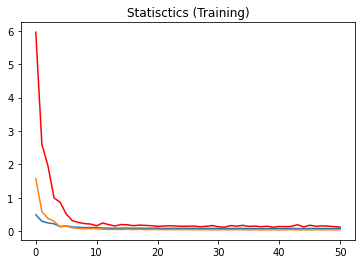

In [33]:
train_model(m1)

# 2. Pooling слои стандартные (1 балла)

*   Опишите своими словами как работает Pooling слой.
*   Взять максимум по временной компоненте (незавимисо для каждой фичи)
*   Взять среднее по временной компоненте (исключая PAD символы)

Применять можно к любой архитектуре (CNN/RNN)

In [34]:
class SalaryPredictorPooling(nn.Module):
    def __init__(self, PoolLayer, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
        )
        
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
        )
        
        self.pooling_1 = PoolLayer(output_size=hid_size)
        self.pooling_2 = PoolLayer(output_size=hid_size)
        
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.LazyLinear(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

        
    def forward(self, batch):
        
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings)
        title_features = self.pooling_1(title_features)
        
        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings)
        description_features = self.pooling_2(description_features)
        
        categorical_features = self.categorical_encoder(batch['Categorical'])
        
        title_features = torch.flatten(title_features, start_dim=1)
        
        description_features = torch.flatten(description_features, start_dim=1)
        
        features = torch.cat([title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [35]:
avg_pooling = nn.AdaptiveAvgPool1d
max_pooling = nn.AdaptiveMaxPool1d

m2 = SalaryPredictorPooling(avg_pooling)
m2 = m2.to(DEVICE)

m3 = SalaryPredictorPooling(max_pooling)
m3 = m3.to(DEVICE)

epoch: 1


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 1.939393162727356
val results:
Mean square error: 0.39359
Mean absolute error: 0.25271
train_loss 0.8125791549682617
val results:
Mean square error: 0.14260
Mean absolute error: 0.14901
train_loss 0.3622407913208008
val results:
Mean square error: 0.06573
Mean absolute error: 0.10200
train_loss 0.4287537932395935
val results:
Mean square error: 0.05317
Mean absolute error: 0.09102
train_loss 0.33881255984306335
val results:
Mean square error: 0.04787
Mean absolute error: 0.08631
train_loss 0.2765350341796875
val results:
Mean square error: 0.04410
Mean absolute error: 0.08189
train_loss 0.24221104383468628
val results:
Mean square error: 0.04107
Mean absolute error: 0.07901
train_loss 0.19228950142860413
val results:
Mean square error: 0.03923
Mean absolute error: 0.07707
train_loss 0.25493839383125305
val results:
Mean square error: 0.03771
Mean absolute error: 0.07524
train_loss 0.23749908804893494
val results:
Mean square error: 0.03701
Mean absolute error: 0.07462
train_

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.1414809674024582
val results:
Mean square error: 0.03201
Mean absolute error: 0.06892
train_loss 0.1302223652601242
val results:
Mean square error: 0.03156
Mean absolute error: 0.06820
train_loss 0.16130799055099487
val results:
Mean square error: 0.03146
Mean absolute error: 0.06828
train_loss 0.1336037516593933
val results:
Mean square error: 0.03093
Mean absolute error: 0.06727
train_loss 0.1735951006412506
val results:
Mean square error: 0.03052
Mean absolute error: 0.06684
train_loss 0.11591079831123352
val results:
Mean square error: 0.03030
Mean absolute error: 0.06679
train_loss 0.13873955607414246
val results:
Mean square error: 0.02961
Mean absolute error: 0.06592
train_loss 0.12380620837211609
val results:
Mean square error: 0.02957
Mean absolute error: 0.06569
train_loss 0.14184562861919403
val results:
Mean square error: 0.02921
Mean absolute error: 0.06516
train_loss 0.09832164645195007
val results:
Mean square error: 0.02866
Mean absolute error: 0.06466
trai

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.12888410687446594
val results:
Mean square error: 0.02629
Mean absolute error: 0.06159
train_loss 0.11046329140663147
val results:
Mean square error: 0.02619
Mean absolute error: 0.06133
train_loss 0.1315738558769226
val results:
Mean square error: 0.02573
Mean absolute error: 0.06067
train_loss 0.1656622290611267
val results:
Mean square error: 0.02562
Mean absolute error: 0.06057
train_loss 0.1147126778960228
val results:
Mean square error: 0.02520
Mean absolute error: 0.05999
train_loss 0.1192646324634552
val results:
Mean square error: 0.02525
Mean absolute error: 0.05998
train_loss 0.08613840490579605
val results:
Mean square error: 0.02495
Mean absolute error: 0.05983
train_loss 0.0905856341123581
val results:
Mean square error: 0.02453
Mean absolute error: 0.05912
train_loss 0.11105553805828094
val results:
Mean square error: 0.02428
Mean absolute error: 0.05886
train_loss 0.07286839187145233
val results:
Mean square error: 0.02418
Mean absolute error: 0.05881
train

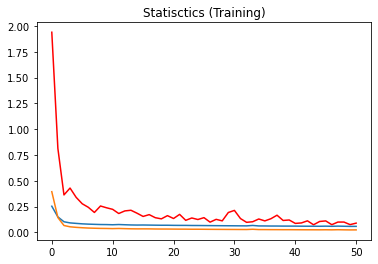

In [36]:
train_model(m2)

epoch: 1


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 1.4434711933135986
val results:
Mean square error: 0.80099
Mean absolute error: 0.40352
train_loss 0.618132472038269
val results:
Mean square error: 1.24449
Mean absolute error: 0.53535
train_loss 0.33472275733947754
val results:
Mean square error: 1.22259
Mean absolute error: 0.53606
train_loss 0.33393752574920654
val results:
Mean square error: 1.11116
Mean absolute error: 0.51230
train_loss 0.22457829117774963
val results:
Mean square error: 1.17920
Mean absolute error: 0.53044
train_loss 0.20742878317832947
val results:
Mean square error: 1.08264
Mean absolute error: 0.50827
train_loss 0.21814079582691193
val results:
Mean square error: 1.19006
Mean absolute error: 0.53467
train_loss 0.23679453134536743
val results:
Mean square error: 1.13767
Mean absolute error: 0.52274
train_loss 0.2434891164302826
val results:
Mean square error: 1.09069
Mean absolute error: 0.51174
train_loss 0.20548699796199799
val results:
Mean square error: 1.17646
Mean absolute error: 0.53261
trai

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.13321807980537415
val results:
Mean square error: 1.18051
Mean absolute error: 0.53501
train_loss 0.14581391215324402
val results:
Mean square error: 1.19205
Mean absolute error: 0.53782
train_loss 0.19825990498065948
val results:
Mean square error: 1.19503
Mean absolute error: 0.53869
train_loss 0.1680474877357483
val results:
Mean square error: 1.09986
Mean absolute error: 0.51624
train_loss 0.16538280248641968
val results:
Mean square error: 1.12432
Mean absolute error: 0.52223
train_loss 0.12702003121376038
val results:
Mean square error: 1.07270
Mean absolute error: 0.50980
train_loss 0.1321275532245636
val results:
Mean square error: 1.22048
Mean absolute error: 0.54497
train_loss 0.10852229595184326
val results:
Mean square error: 1.18548
Mean absolute error: 0.53694
train_loss 0.15962281823158264
val results:
Mean square error: 1.19636
Mean absolute error: 0.53956
train_loss 0.14256349205970764
val results:
Mean square error: 1.08573
Mean absolute error: 0.51338
tr

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.10777472704648972
val results:
Mean square error: 1.19321
Mean absolute error: 0.53947
train_loss 0.10244672000408173
val results:
Mean square error: 1.14120
Mean absolute error: 0.52734
train_loss 0.095993272960186
val results:
Mean square error: 1.19017
Mean absolute error: 0.53887
train_loss 0.14405031502246857
val results:
Mean square error: 1.20438
Mean absolute error: 0.54221
train_loss 0.10565157234668732
val results:
Mean square error: 1.17161
Mean absolute error: 0.53462
train_loss 0.10256016254425049
val results:
Mean square error: 1.19331
Mean absolute error: 0.53975
train_loss 0.0805494487285614
val results:
Mean square error: 1.15302
Mean absolute error: 0.53039
train_loss 0.10233171284198761
val results:
Mean square error: 1.17858
Mean absolute error: 0.53644
train_loss 0.11965619027614594
val results:
Mean square error: 1.21587
Mean absolute error: 0.54512
train_loss 0.08513270318508148
val results:
Mean square error: 1.10424
Mean absolute error: 0.51888
tra

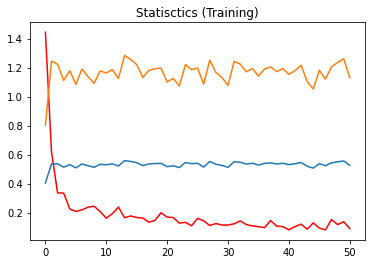

In [37]:
train_model(m3)

# 3. Используйте предобученные эмбеддинги (2 балла)

*   Загрузите предобученные эмбеддинги с помощью gensim.downloader.load
*   Используйте метод [from_pretrained](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) слоя torch.nn.Embedding для инициализации эмбеддингов с помощью предобученных весов. Можете попбровать несколько типов предобученных эмбеддингов.
*   Проведите эксперементы с обучаемыми/замороженными весами эмбеддингов.
Используйте одни и те же эмбеддинги для Title и FullDescription.

Сравните результаты:
1.   Эмбеддингов, инициализируемых случайно из $$\mathcal{N}(0,1)$$ (по умолчанию у слоя torch.nn.Embedding)
2.   Предобученных эмбеддингов с замороженными весами
3.   Предобученных эмбеддингов с обучаемыми весами

Что изменяется в поведении модели? Какой эксперимент дал лучший результат?

In [38]:
import gensim.downloader as loader

def load_weights(title):
    weights = loader.load(title)
    weights = torch.FloatTensor(weights.vectors)
    return weights
    
    

In [39]:
title = "glove-wiki-gigaword-50"
weights = load_weights(title)
size = int(title.split("-")[-1])

# self.embedder = nn.Embedding.from_pretrained(weights)

In [40]:
class SalaryPredictorE(nn.Module):
    def __init__(self, weights, freeze, size, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        
        self.embedder = nn.Embedding.from_pretrained(weights)
        
        self.embedder.requires_grad_ = freeze
        
        self.title_encoder = nn.Sequential(
            nn.Conv1d(size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()
        
        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()
        
        categorical_features = self.categorical_encoder(batch['Categorical'])
        features = torch.cat([title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [41]:
m4 = SalaryPredictorE(weights=weights, freeze=True, size=size)
m4 = m4.to(DEVICE)

m5 = SalaryPredictorE(weights=weights, freeze=False, size=size)
m5 = m5.to(DEVICE)

epoch: 1


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.7709019184112549
val results:
Mean square error: 0.82449
Mean absolute error: 0.42660
train_loss 0.44182655215263367
val results:
Mean square error: 1.35138
Mean absolute error: 0.56420
train_loss 0.30383288860321045
val results:
Mean square error: 1.33559
Mean absolute error: 0.56284
train_loss 0.32535603642463684
val results:
Mean square error: 1.27696
Mean absolute error: 0.55120
train_loss 0.2859098017215729
val results:
Mean square error: 1.27954
Mean absolute error: 0.55309
train_loss 0.21489092707633972
val results:
Mean square error: 1.24063
Mean absolute error: 0.54524
train_loss 0.3065643310546875
val results:
Mean square error: 1.23780
Mean absolute error: 0.54522
train_loss 0.3320041298866272
val results:
Mean square error: 1.19078
Mean absolute error: 0.53485
train_loss 0.20273101329803467
val results:
Mean square error: 1.18693
Mean absolute error: 0.53430
train_loss 0.17822939157485962
val results:
Mean square error: 1.14883
Mean absolute error: 0.52573
trai

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.19770345091819763
val results:
Mean square error: 1.03247
Mean absolute error: 0.49863
train_loss 0.12440779060125351
val results:
Mean square error: 1.04584
Mean absolute error: 0.50215
train_loss 0.16640684008598328
val results:
Mean square error: 1.05059
Mean absolute error: 0.50343
train_loss 0.16178730130195618
val results:
Mean square error: 1.05226
Mean absolute error: 0.50391
train_loss 0.1692323088645935
val results:
Mean square error: 1.01676
Mean absolute error: 0.49517
train_loss 0.15611012279987335
val results:
Mean square error: 0.93734
Mean absolute error: 0.47476
train_loss 0.15123599767684937
val results:
Mean square error: 0.97937
Mean absolute error: 0.48579
train_loss 0.16652891039848328
val results:
Mean square error: 0.93888
Mean absolute error: 0.47533
train_loss 0.19017168879508972
val results:
Mean square error: 0.98000
Mean absolute error: 0.48607
train_loss 0.14933788776397705
val results:
Mean square error: 0.99484
Mean absolute error: 0.48997
t

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.1352011263370514
val results:
Mean square error: 0.88965
Mean absolute error: 0.46288
train_loss 0.1343534141778946
val results:
Mean square error: 0.86422
Mean absolute error: 0.45612
train_loss 0.11240138113498688
val results:
Mean square error: 0.85200
Mean absolute error: 0.45283
train_loss 0.13554641604423523
val results:
Mean square error: 0.88230
Mean absolute error: 0.46116
train_loss 0.11650313436985016
val results:
Mean square error: 0.84806
Mean absolute error: 0.45185
train_loss 0.11005214601755142
val results:
Mean square error: 0.84198
Mean absolute error: 0.45021
train_loss 0.160173237323761
val results:
Mean square error: 0.85531
Mean absolute error: 0.45391
train_loss 0.14272981882095337
val results:
Mean square error: 0.82400
Mean absolute error: 0.44534
train_loss 0.14350232481956482
val results:
Mean square error: 0.78960
Mean absolute error: 0.43560
train_loss 0.13522320985794067
val results:
Mean square error: 0.82927
Mean absolute error: 0.44689
trai

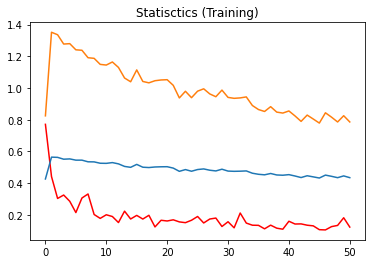

In [42]:
train_model(m4)

epoch: 1


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 23.926250457763672
val results:
Mean square error: 9.16073
Mean absolute error: 1.50771
train_loss 0.463827908039093
val results:
Mean square error: 1.43169
Mean absolute error: 0.57975
train_loss 0.37029290199279785
val results:
Mean square error: 1.37198
Mean absolute error: 0.56900
train_loss 0.2777215838432312
val results:
Mean square error: 1.31957
Mean absolute error: 0.56003
train_loss 0.40804219245910645
val results:
Mean square error: 1.26782
Mean absolute error: 0.54968
train_loss 0.38669848442077637
val results:
Mean square error: 1.19087
Mean absolute error: 0.53328
train_loss 0.27091729640960693
val results:
Mean square error: 1.13466
Mean absolute error: 0.52067
train_loss 0.19016900658607483
val results:
Mean square error: 1.14012
Mean absolute error: 0.52286
train_loss 0.15417230129241943
val results:
Mean square error: 1.12182
Mean absolute error: 0.51888
train_loss 0.1849655658006668
val results:
Mean square error: 1.15948
Mean absolute error: 0.52861
train

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.1906311959028244
val results:
Mean square error: 1.02971
Mean absolute error: 0.49809
train_loss 0.13289567828178406
val results:
Mean square error: 1.07661
Mean absolute error: 0.51003
train_loss 0.15207326412200928
val results:
Mean square error: 1.05802
Mean absolute error: 0.50559
train_loss 0.17409038543701172
val results:
Mean square error: 0.99599
Mean absolute error: 0.48950
train_loss 0.14552614092826843
val results:
Mean square error: 1.02574
Mean absolute error: 0.49763
train_loss 0.17963583767414093
val results:
Mean square error: 0.98576
Mean absolute error: 0.48726
train_loss 0.14367404580116272
val results:
Mean square error: 1.02678
Mean absolute error: 0.49801
train_loss 0.10112597048282623
val results:
Mean square error: 1.04124
Mean absolute error: 0.50177
train_loss 0.15677037835121155
val results:
Mean square error: 1.00254
Mean absolute error: 0.49195
train_loss 0.13820254802703857
val results:
Mean square error: 0.99856
Mean absolute error: 0.49110
t

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.09126049280166626
val results:
Mean square error: 0.95476
Mean absolute error: 0.47988
train_loss 0.16474246978759766
val results:
Mean square error: 0.97531
Mean absolute error: 0.48596
train_loss 0.11351057887077332
val results:
Mean square error: 0.93517
Mean absolute error: 0.47495
train_loss 0.11658701300621033
val results:
Mean square error: 0.93604
Mean absolute error: 0.47520
train_loss 0.12786465883255005
val results:
Mean square error: 0.93649
Mean absolute error: 0.47585
train_loss 0.11468106508255005
val results:
Mean square error: 0.98777
Mean absolute error: 0.48894
train_loss 0.11915779858827591
val results:
Mean square error: 0.94369
Mean absolute error: 0.47750
train_loss 0.10169631242752075
val results:
Mean square error: 0.96940
Mean absolute error: 0.48461
train_loss 0.15102772414684296
val results:
Mean square error: 0.93334
Mean absolute error: 0.47461
train_loss 0.15835249423980713
val results:
Mean square error: 0.91264
Mean absolute error: 0.46958


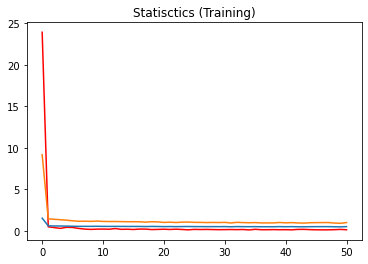

In [43]:
train_model(m5)

# 4. Замените сверточные слои на рекуррентные (3 балла)

* Замените сверточне слоим рекуррентными LSTM/GRU.
* Проведите эксперимент с однонаправленной и двунаправленной рекуррентной нейросетью
* Попробуйте найти удачный микс рекуррентных и сверточных слоев. Попробуйте разные миксы для Title и FullDescription

In [44]:
class SalaryPredictorReccurent(nn.Module):
    def __init__(self, ReccurentLayer, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        
        self.title_reccurent = nn.Sequential(nn.AdaptiveMaxPool1d(hid_size),
            ReccurentLayer(hid_size, 
                                              hid_size, 
                                              num_layers=2, 
                                              bidirectional=True))
        
        self.description_reccurent = nn.Sequential(nn.AdaptiveMaxPool1d(hid_size),
            ReccurentLayer(hid_size, 
                                              hid_size, 
                                              num_layers=2, 
                                              bidirectional=True))
        
        
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.LazyLinear(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

        
    def forward(self, batch):

        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_reccurent(title_embeddings)[0]
        title_features = self.title_encoder(title_embeddings).squeeze()
        
        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_reccurent(description_embeddings)[0]
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [45]:
rnn = nn.RNN

lstm = nn.LSTM

gru = nn.GRU

m6 = SalaryPredictorReccurent(rnn)

m7 = SalaryPredictorReccurent(lstm)

m8 = SalaryPredictorReccurent(gru)

m6 = m6.to(DEVICE)

m7 = m7.to(DEVICE)

m8 = m8.to(DEVICE)

epoch: 1


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 4.506007194519043
val results:
Mean square error: 3.28221
Mean absolute error: 0.89421
train_loss 0.4511946141719818
val results:
Mean square error: 1.17138
Mean absolute error: 0.52118
train_loss 0.381965696811676
val results:
Mean square error: 1.17161
Mean absolute error: 0.52341
train_loss 0.31006449460983276
val results:
Mean square error: 1.14192
Mean absolute error: 0.51811
train_loss 0.2449975609779358
val results:
Mean square error: 1.13383
Mean absolute error: 0.51798
train_loss 0.30646657943725586
val results:
Mean square error: 1.10069
Mean absolute error: 0.51103
train_loss 0.2965695858001709
val results:
Mean square error: 1.08410
Mean absolute error: 0.50774
train_loss 0.23951254785060883
val results:
Mean square error: 1.03187
Mean absolute error: 0.49537
train_loss 0.22679078578948975
val results:
Mean square error: 1.00214
Mean absolute error: 0.48833
train_loss 0.1988476812839508
val results:
Mean square error: 1.00558
Mean absolute error: 0.48963
train_lo

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.1774623692035675
val results:
Mean square error: 0.76892
Mean absolute error: 0.42728
train_loss 0.12519752979278564
val results:
Mean square error: 0.75823
Mean absolute error: 0.42437
train_loss 0.13646848499774933
val results:
Mean square error: 0.76368
Mean absolute error: 0.42613
train_loss 0.20044739544391632
val results:
Mean square error: 0.74589
Mean absolute error: 0.42107
train_loss 0.12045328319072723
val results:
Mean square error: 0.72414
Mean absolute error: 0.41475
train_loss 0.1341804563999176
val results:
Mean square error: 0.68264
Mean absolute error: 0.40222
train_loss 0.18936535716056824
val results:
Mean square error: 0.69967
Mean absolute error: 0.40769
train_loss 0.11356647312641144
val results:
Mean square error: 0.67303
Mean absolute error: 0.39958
train_loss 0.13262416422367096
val results:
Mean square error: 0.67091
Mean absolute error: 0.39907
train_loss 0.10765774548053741
val results:
Mean square error: 0.65805
Mean absolute error: 0.39513
tr

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.13970382511615753
val results:
Mean square error: 0.53416
Mean absolute error: 0.35482
train_loss 0.11920646578073502
val results:
Mean square error: 0.50272
Mean absolute error: 0.34365
train_loss 0.12989525496959686
val results:
Mean square error: 0.55949
Mean absolute error: 0.36375
train_loss 0.11985136568546295
val results:
Mean square error: 0.47892
Mean absolute error: 0.33506
train_loss 0.11866767704486847
val results:
Mean square error: 0.48963
Mean absolute error: 0.33912
train_loss 0.12948906421661377
val results:
Mean square error: 0.41741
Mean absolute error: 0.31156
train_loss 0.1193416491150856
val results:
Mean square error: 0.48356
Mean absolute error: 0.33706
train_loss 0.16412019729614258
val results:
Mean square error: 0.42333
Mean absolute error: 0.31398
train_loss 0.11502313613891602
val results:
Mean square error: 0.43091
Mean absolute error: 0.31708
train_loss 0.1321728527545929
val results:
Mean square error: 0.44813
Mean absolute error: 0.32394
tr

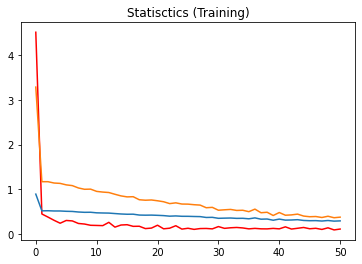

In [46]:
train_model(m6)

epoch: 1


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 41.12651062011719
val results:
Mean square error: 12.06794
Mean absolute error: 1.73250
train_loss 0.5056960582733154
val results:
Mean square error: 0.66842
Mean absolute error: 0.38256
train_loss 0.35632890462875366
val results:
Mean square error: 0.63279
Mean absolute error: 0.37416
train_loss 0.3606700897216797
val results:
Mean square error: 0.59815
Mean absolute error: 0.36623
train_loss 0.2660018801689148
val results:
Mean square error: 0.57274
Mean absolute error: 0.35960
train_loss 0.22565165162086487
val results:
Mean square error: 0.58330
Mean absolute error: 0.36439
train_loss 0.2542216181755066
val results:
Mean square error: 0.57800
Mean absolute error: 0.36346
train_loss 0.26035889983177185
val results:
Mean square error: 0.56108
Mean absolute error: 0.35837
train_loss 0.24342608451843262
val results:
Mean square error: 0.56411
Mean absolute error: 0.36003
train_loss 0.23787041008472443
val results:
Mean square error: 0.56594
Mean absolute error: 0.36111
train

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.17253538966178894
val results:
Mean square error: 0.45815
Mean absolute error: 0.32442
train_loss 0.1856745481491089
val results:
Mean square error: 0.45073
Mean absolute error: 0.32173
train_loss 0.17641308903694153
val results:
Mean square error: 0.44674
Mean absolute error: 0.32037
train_loss 0.17606353759765625
val results:
Mean square error: 0.43050
Mean absolute error: 0.31413
train_loss 0.2098221480846405
val results:
Mean square error: 0.45406
Mean absolute error: 0.32349
train_loss 0.19376729428768158
val results:
Mean square error: 0.43598
Mean absolute error: 0.31661
train_loss 0.1434989869594574
val results:
Mean square error: 0.42569
Mean absolute error: 0.31268
train_loss 0.16321107745170593
val results:
Mean square error: 0.40353
Mean absolute error: 0.30387
train_loss 0.17031648755073547
val results:
Mean square error: 0.38851
Mean absolute error: 0.29786
train_loss 0.16414546966552734
val results:
Mean square error: 0.40765
Mean absolute error: 0.30589
tra

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.14174532890319824
val results:
Mean square error: 0.34649
Mean absolute error: 0.28094
train_loss 0.12305030971765518
val results:
Mean square error: 0.33265
Mean absolute error: 0.27493
train_loss 0.10041476786136627
val results:
Mean square error: 0.34028
Mean absolute error: 0.27845
train_loss 0.1296548843383789
val results:
Mean square error: 0.33910
Mean absolute error: 0.27803
train_loss 0.10094166547060013
val results:
Mean square error: 0.33030
Mean absolute error: 0.27424
train_loss 0.13351783156394958
val results:
Mean square error: 0.29171
Mean absolute error: 0.25622
train_loss 0.10194748640060425
val results:
Mean square error: 0.30567
Mean absolute error: 0.26304
train_loss 0.12500210106372833
val results:
Mean square error: 0.31035
Mean absolute error: 0.26533
train_loss 0.13569170236587524
val results:
Mean square error: 0.30337
Mean absolute error: 0.26223
train_loss 0.10860153287649155
val results:
Mean square error: 0.28843
Mean absolute error: 0.25505
t

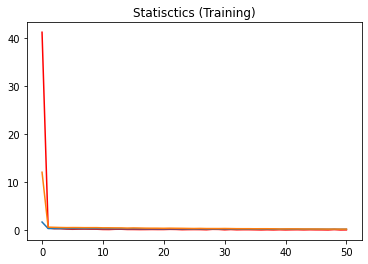

In [47]:
train_model(m7)

epoch: 1


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 7.6861162185668945
val results:
Mean square error: 3.73081
Mean absolute error: 0.95059
train_loss 0.6887085437774658
val results:
Mean square error: 0.87702
Mean absolute error: 0.43692
train_loss 0.5308180451393127
val results:
Mean square error: 0.84383
Mean absolute error: 0.43423
train_loss 0.4112987518310547
val results:
Mean square error: 0.82114
Mean absolute error: 0.43223
train_loss 0.323766827583313
val results:
Mean square error: 0.80636
Mean absolute error: 0.43052
train_loss 0.31998661160469055
val results:
Mean square error: 0.77290
Mean absolute error: 0.42262
train_loss 0.3540771007537842
val results:
Mean square error: 0.73311
Mean absolute error: 0.41215
train_loss 0.20004431903362274
val results:
Mean square error: 0.79514
Mean absolute error: 0.43150
train_loss 0.26178205013275146
val results:
Mean square error: 0.71310
Mean absolute error: 0.40797
train_loss 0.18151360750198364
val results:
Mean square error: 0.69795
Mean absolute error: 0.40394
train_l

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.17960044741630554
val results:
Mean square error: 0.60055
Mean absolute error: 0.37543
train_loss 0.20575085282325745
val results:
Mean square error: 0.58405
Mean absolute error: 0.37008
train_loss 0.125962495803833
val results:
Mean square error: 0.55864
Mean absolute error: 0.36156
train_loss 0.12541991472244263
val results:
Mean square error: 0.54117
Mean absolute error: 0.35563
train_loss 0.13535475730895996
val results:
Mean square error: 0.53510
Mean absolute error: 0.35368
train_loss 0.12551389634609222
val results:
Mean square error: 0.55662
Mean absolute error: 0.36135
train_loss 0.14128674566745758
val results:
Mean square error: 0.49902
Mean absolute error: 0.34102
train_loss 0.14238515496253967
val results:
Mean square error: 0.49526
Mean absolute error: 0.33978
train_loss 0.12466929852962494
val results:
Mean square error: 0.48693
Mean absolute error: 0.33687
train_loss 0.13855701684951782
val results:
Mean square error: 0.49384
Mean absolute error: 0.33951
tr

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.10893993079662323
val results:
Mean square error: 0.40786
Mean absolute error: 0.30727
train_loss 0.12249764800071716
val results:
Mean square error: 0.40375
Mean absolute error: 0.30567
train_loss 0.10159613937139511
val results:
Mean square error: 0.40848
Mean absolute error: 0.30774
train_loss 0.12403831630945206
val results:
Mean square error: 0.38510
Mean absolute error: 0.29818
train_loss 0.10331544280052185
val results:
Mean square error: 0.36559
Mean absolute error: 0.29001
train_loss 0.14611993730068207
val results:
Mean square error: 0.36782
Mean absolute error: 0.29098
train_loss 0.11262522637844086
val results:
Mean square error: 0.33668
Mean absolute error: 0.27749
train_loss 0.13556008040905
val results:
Mean square error: 0.35474
Mean absolute error: 0.28554
train_loss 0.12938469648361206
val results:
Mean square error: 0.33096
Mean absolute error: 0.27508
train_loss 0.1380579024553299
val results:
Mean square error: 0.35853
Mean absolute error: 0.28737
trai

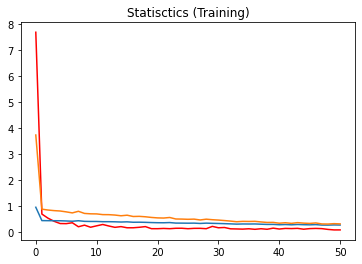

In [48]:
train_model(m8)

# 5. Вытащите признаки из нейронной сети и используйте их в ансамбле деревьев решений. (2 балла)

* Вытащите признаки с предпоследнего слоя обученной нейросети и передайте их в ансамбль деревьев решений.
* Сравните результаты работы лучшей нейросети и ансамбля деревьев решений, построенном на признаках из этой нейросети. Сможет ли замена последнего слоя на ансамбль деревьев решений улучшить результат?

In [49]:
import random

# gru model

class ModelInference(object):
    def __init__(self, model):
        
        self.model = model
        
    def inference(self, data) -> "features in numpy arrays":
        
        x=[[]]
        y=[]
        x=np.array(x)
        y=np.array(y)
        
        for i, batch in tqdm.notebook.tqdm(enumerate(
                        iterate_minibatches(
                                data, 
                                batch_size=BATCH_SIZE, 
                                device=DEVICE)), 
                            total=len(data) // BATCH_SIZE
                    ):
            title_embeddings = self.model.embedder(batch['Title']).permute(0, 2, 1)
            title_features = self.model.title_reccurent(title_embeddings)[0]
            title_features = self.model.title_encoder(title_embeddings).squeeze()

            description_embeddings = self.model.embedder(batch['FullDescription']).permute(0, 2, 1)
            description_features = self.model.description_reccurent(description_embeddings)[0]
            description_features = self.model.description_encoder(description_embeddings).squeeze()

            categorical_features = self.model.categorical_encoder(batch['Categorical'])
            
            f = torch.cat([title_features, description_features, categorical_features], dim=1).detach().cpu().numpy()
            
            if x.any(): 
                x = np.concatenate([x, f])
            else: 
                x = f
                
                
            if y.any(): 
                y = np.concatenate([y, batch[TARGET_COLUMN].cpu().numpy()])
            else: 
                y = batch[TARGET_COLUMN].cpu().numpy()
            
        return x, y

In [50]:
m9 = ModelInference(m8)

In [51]:
train_x, train_y = m9.inference(data_train)
test_x, test_y = m9.inference(data_val)

  0%|          | 0/1721 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

In [52]:
from sklearn.tree import DecisionTreeRegressor


class TreeForest(object):
    
    def __init__(self, n_estimatros, min_depth=2, max_depth=5):
        self.models = []
        
        for _ in range(n_estimatros):
            
            depth = random.randint(min_depth, max_depth)
            new_model = DecisionTreeRegressor(max_depth=depth)
            self.models.append(new_model)
        
        self.n_estimatros = n_estimatros
        
    def fit(self, x, y):
        for t in self.models:
            t.fit(x, y)
            
    def predict(self, x):
        predictions = []
        
        self._p = None
        
        for model in self.models:
            pred = model.predict(x)
            predictions.append(pred)
        
        pred = np.sum(predictions, axis=0) / self.n_estimatros
        
        self._p = pred
        
        return pred
    
    def evaluate(self, y):
        
        mse = np.mean(np.square(self._p - y))
        mae = np.mean(np.abs(self._p - y))
        return mse, mae

In [53]:
m10 = TreeForest(4)

m10.fit(train_x, train_y)

In [54]:
m10.predict(test_x)

array([10.49299027, 10.44656257, 10.10863227, ..., 10.24061041,
       10.10863227, 10.53042684])

In [55]:
m10.evaluate(test_y)

(0.14709391968819982, 0.2983686946441363)

Океюшки, лаборатори ворк из done :))

Давайте прорезюмируем чего мы тут наворотили


1. Придумали сетку с параллельными блоками из сверточных и дополнительных слоев
Результаты отличные, в целом ок. Мы повысили емкость сети, а данные однообразные, поэтому это дало прирост, я так думаю.

2. Average Pool улучшил результаты базовой модели, Max pool не показал прироста к производительности.

3. Эмбединги не повысили результаты, и производительность. Хотя на накоторых итерациях очередной тренировке модель быстрее сходилась к оптимуму.

4. GRU показали себя лучше всех. Не могу объяснить почему, хотя LSTM это почти то же самое. RNN в целом тоже ок, но последней сетке проигрывает.

5. Ансамбль деревьев решений показал хороший результат с фичами, полученными на GRU сетке, которым в целом можно гордиться. Не зря машинное обучение изучали))